<a href="https://colab.research.google.com/github/tandem-team/Machine-Learning-Collection/blob/master/Inference_Torchvision_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Torchvision Model Inference

Pytorch introduced its own computer vision library with many image transformation operations included. The library also included many of the common datasets and more importantly pre-trained models that can directly be used for inference with minimum effort. The pre-trained models are present in "models" subpackage of torchvision.

This notebook intends to showcase the usage of torchvision models designed for object detection and localization.
\
https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
\
We will also see the inference timing of some of these models on CPU and GPU.
\
First we'll look at the "Faster R-CNN model with a ResNet-50-FPN backbone".


In [ ]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import time

import ipywidgets as widgets
from IPython.display import display


# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

The following are two helper functions which returns the input image with bounding boxes enclosing the detected objects.
\
Line 16-19 : Input image is loaded using PIL library function and applied a transformation to convert it to tensor and then is passed through the model.
\
The predictions recieved are of type [dict{ 'boxes': tensor([ list of boxes ]) , 'labels':tensor([list of labels]) , 'scores':tensor([list of scores]) }]
\
Line 20-22 : The output dictionary is parsed and 'labels', 'boxes' and 'scores' are retireved into 3 different lists
\
Line 23 : The scores given by the model are in descending order which we split at the index where the score values are greater than a selected threshold.
\
Line 24-25 : Filter the boxes and labels based on the previous index.
\
Line 28 : The function and detect and display is a simple annotation of the input image with the predictions using opencv's "cv2.rectangle" and "cv2.putText" functions.


In [3]:
#Helper function to run the inference given a model
def get_prediction(img_path, threshold, model_t):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model_t([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class
    
def detect_and_display(img_path, model_t, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    """
    detect_and_display
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thickness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
    """
    boxes, pred_cls = get_prediction(img_path, threshold, model_t)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

The next 2 cells run inference on images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


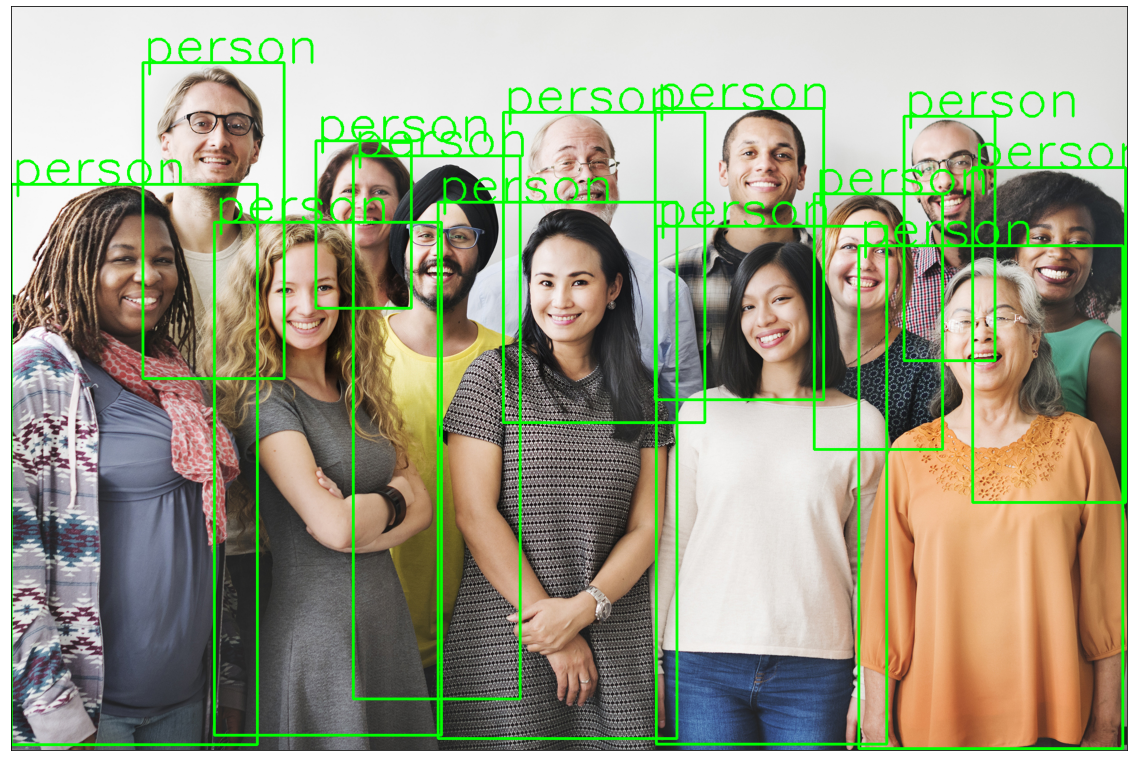

In [4]:
# download an image for inference
!wget -q https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

# use the api pipeline for object detection
# the threshold is set manually, the model sometimes predict 
# random structures as some object, so we set a threshold to filter
# better prediction scores.
detect_and_display('./people.jpg', model_t=model, threshold=0.8)

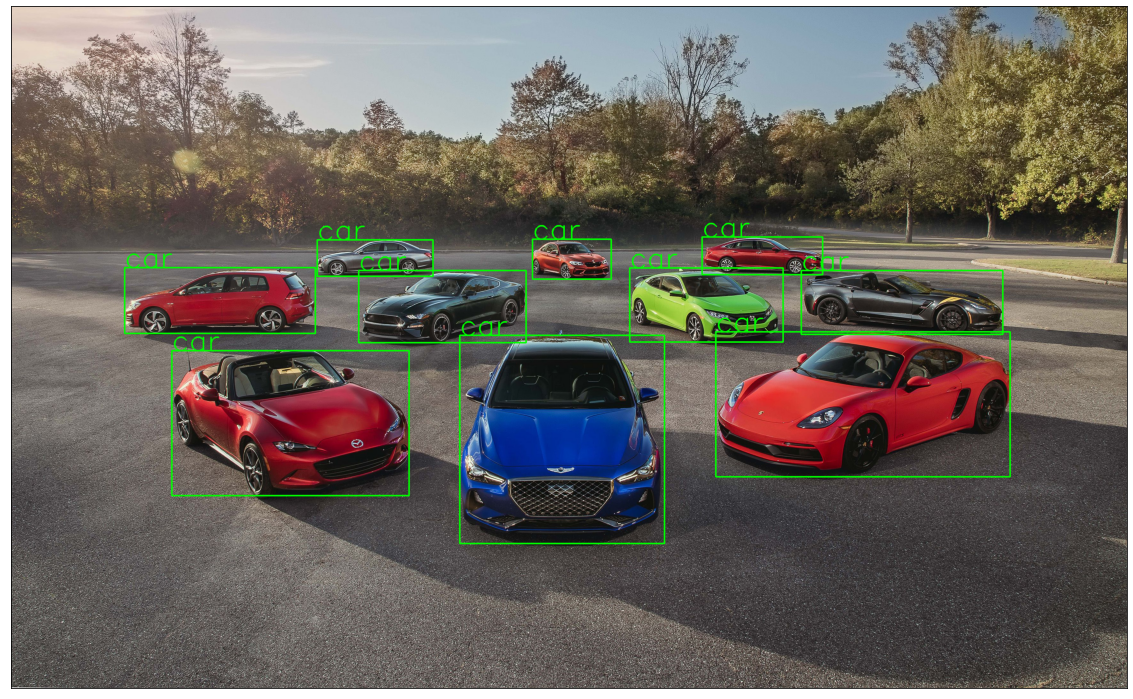

In [6]:
# download another image for inference
!wget -q https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O many_cars.jpg

detect_and_display('./many_cars.jpg', model_t=model, threshold=0.8)

The following cell has created a dropdown which will enable you to select a model among the available and run inference using the same.
\
Line 4-10 : Create the "selected model" variable and the dropdown widget.
\
Line 18 : The selected model from the dropdown is evaluated and assigned to "model_sel".

In [ ]:
#The model selection stage
#From the dropdown in the output, please select a model

model_sel=model
dropdown_model_sel = widgets.Dropdown(options = ['default-fasterrcnn_resnet50_fpn',\
                                            'retinanet_resnet50_fpn', \
                                            'maskrcnn_resnet50_fpn', \
                                            'keypointrcnn_resnet50_fpn', \
                                            'ssd300_vgg16'])
output_info = widgets.Output()

def dropdown_model_sel_Eventhandler(input_val):
    output_info.clear_output()
    global model_sel
    with output_info:
        model_sel = input_val.new
        print(model_sel.replace('default-', ''))
        model_sel = eval('torchvision.models.detection.'+model_sel.replace('default-', '')+'(pretrained=True)')
        model_sel.eval()

dropdown_model_sel.observe(dropdown_model_sel_Eventhandler, names='value')
display(dropdown_model_sel)
display(output_info)

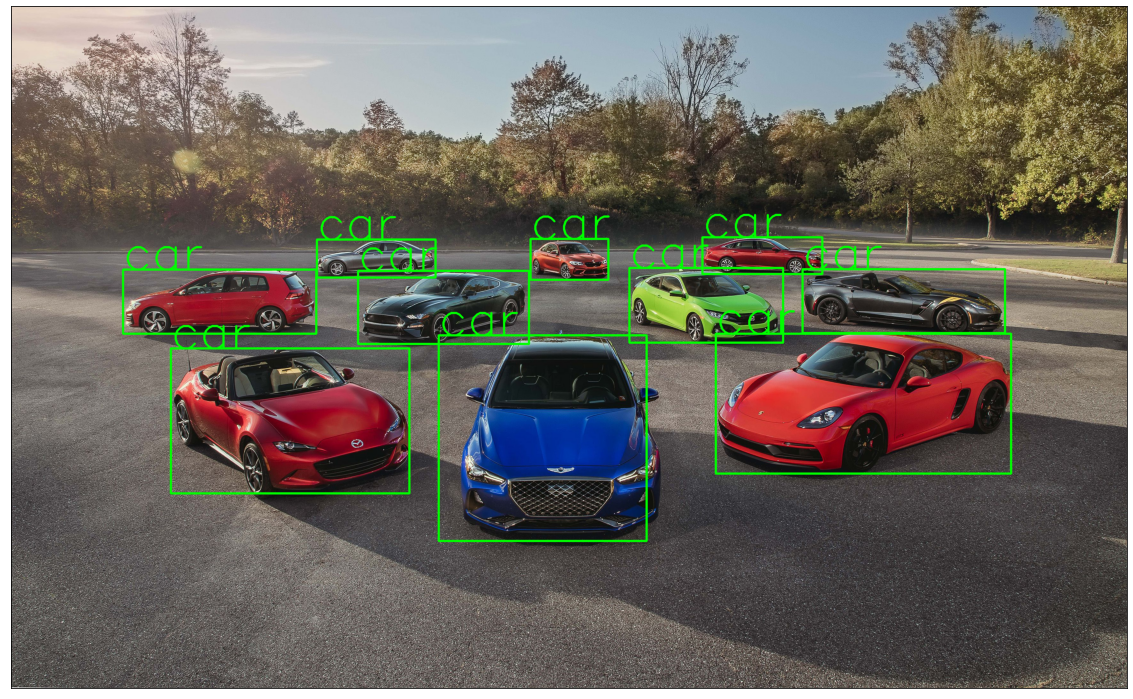

In [9]:
#Select a model in dropdown -> Run this cell again (No need to run the above cell after selecting the dropdown)
!wget -q https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O cars.jpg
  
detect_and_display('./cars.jpg', model_t=model_sel, rect_th=6, text_th=5, text_size=5)

Next, we'll compare the inference times for all the models used above.
\
Line 2-3 : model is selected as before.
\
Line 4-6 : image is loaded with PIL and transformed as before.
\
Line 7-16 : Based on gpu switch, appropriate model is selected and the inference time is measured.

In [10]:
def check_inference_time(image_path, model_t=model_sel, gpu=False):
    model_t = eval('torchvision.models.detection.' + model_t + '(pretrained=True)')
    model_t.eval()
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    if gpu:
        model_t.cuda()
        img = img.cuda()
    else:
        model_t.cpu()
        img = img.cpu()
    start_time = time.time()
    pred = model_t([img])
    end_time = time.time()
    return end_time-start_time

Here CPU times of all models are compared by keeping the gpu switch off.

In [ ]:
testCount=10
inf_test_img = './cars.jpg'
cpu_time = sum([check_inference_time(inf_test_img, 'fasterrcnn_resnet50_fpn', gpu=False) for _ in range(testCount)])/testCount
cpu_time1 = sum([check_inference_time(inf_test_img, 'retinanet_resnet50_fpn', gpu=False) for _ in range(testCount)])/testCount
cpu_time2 = sum([check_inference_time(inf_test_img, 'maskrcnn_resnet50_fpn', gpu=False) for _ in range(testCount)])/testCount
cpu_time3 = sum([check_inference_time(inf_test_img, 'keypointrcnn_resnet50_fpn', gpu=False) for _ in range(testCount)])/testCount
cpu_time4 = sum([check_inference_time(inf_test_img, 'ssd300_vgg16', gpu=False) for _ in range(testCount)])/testCount



print('\n\nAverage Time taken by the fasterrcnn_resnet50_fpn with CPU   = {}s\n\
            \rAverage Timen take by the retinanet_resnet50_fpn with CPU    = {}s\n\
            \rAverage Timen take by the maskrcnn_resnet50_fpn with CPU     = {}s\n\
            \rAverage Timen take by the keypointrcnn_resnet50_fpn with CPU = {}s\n\
            \rAverage Timen take by the ssd300_vgg16 with CPU              = {}s\n'
      .format(cpu_time, cpu_time1, cpu_time2, cpu_time3, cpu_time4))

Corresponding GPU times.

In [ ]:
testCount=10
inf_test_img = './cars.jpg'
gpu_time0 = sum([check_inference_time(inf_test_img, 'fasterrcnn_resnet50_fpn', gpu=True) for _ in range(testCount)])/testCount
gpu_time1 = sum([check_inference_time(inf_test_img, 'retinanet_resnet50_fpn', gpu=True) for _ in range(testCount)])/testCount
gpu_time2 = sum([check_inference_time(inf_test_img, 'maskrcnn_resnet50_fpn', gpu=True) for _ in range(testCount)])/testCount
gpu_time3 = sum([check_inference_time(inf_test_img, 'keypointrcnn_resnet50_fpn', gpu=True) for _ in range(testCount)])/testCount
gpu_time4 = sum([check_inference_time(inf_test_img, 'ssd300_vgg16', gpu=True) for _ in range(testCount)])/testCount



print('\n\nAverage Time taken by the fasterrcnn_resnet50_fpn with GPU   = {}s\n\
            \rAverage Timen take by the retinanet_resnet50_fpn with GPU    = {}s\n\
            \rAverage Timen take by the maskrcnn_resnet50_fpn with GPU     = {}s\n\
            \rAverage Timen take by the keypointrcnn_resnet50_fpn with GPU = {}s\n\
            \rAverage Timen take by the ssd300_vgg16 with GPU              = {}s\n'
      .format(gpu_time0, gpu_time1, gpu_time2, gpu_time3, gpu_time4))